# CIFAR10 Classification

### HW2 @ DL Course, Dr. Soleymani

*Full Name:* Amirhossein Alamdar

*SID:* 400105144

In this part of the assignment we want to do an image classification task using PyTorch on CIFAR10 dataset.

## Import Libraries

Import needed libraries

In [34]:
import torch
import torchvision
from torchvision import transforms

## Device

Set device to work with (GPU or CPU)

In [35]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [36]:
config = {
    'batch_size': 64,
    'lr': 1e-4,
    'weight_decay': 1e-4,
    'patience': 5,
    'epochs': 24
}

## Transforms & Dataset & Dataloader

Here, you should download and load the dataset with the desire transforms. After that, you should split train dataset to train and validation sets. Finally, define the dataloaders for `train`, `validation` and `test`

In [37]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [38]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.20, 0.20, 0.20))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.20, 0.20, 0.20))
])

In [39]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
        self.inv_normalize = transforms.Normalize(mean=[-0.5/0.2, -0.5/0.2, -0.5/0.2], std=[1/0.2, 1/0.2, 1/0.2])
    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be unnormalized.
        Returns:
            Tensor: Unnormalized image.
        """
        tensor = self.inv_normalize(tensor)
        return tensor
    
norminv = UnNormalize(mean=(0.5, 0.5, 0.5), std=(0.20, 0.20, 0.20))

In [40]:
initial_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

Files already downloaded and verified


In [41]:
dataset_len = len(initial_trainset)
trainset, valset = train_set, test_set = torch.utils.data.random_split(initial_trainset, [int(0.9 * dataset_len),int( 0.1 * dataset_len)])

In [42]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=config['batch_size'], shuffle=True)
valloader =  torch.utils.data.DataLoader(valset, batch_size=config['batch_size'], shuffle=False)

In [43]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=config['batch_size'], shuffle=False)

Files already downloaded and verified


## Visualization

Visualize 5 random images from each class in different columns

- **Hint**:  You can use `plt.subplots` for visualization

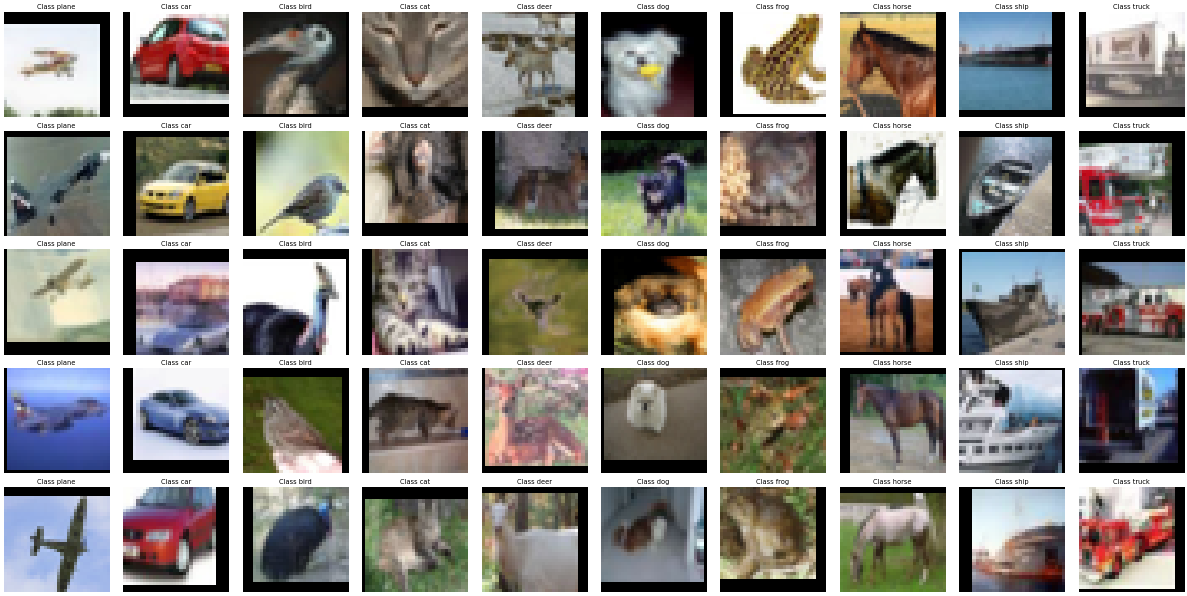

In [44]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.dpi'] = 40  

def show_images(images, titles, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    for i in range(rows):
        for j in range(cols):
            ax = axes[i][j]
            ax.imshow(norminv(images[j][i]).permute(1, 2, 0))
            ax.set_title(titles[j])
            ax.axis('off')
    plt.tight_layout()
    plt.show()

image_shape = (3, 32, 32)

num_classes = 10

class_images = [[] for _ in range(num_classes)]

for image, label in train_set:
    if len(class_images[label]) < 5:
        class_images[label].append(image)
    if all(len(images) == 5 for images in class_images):
        break

class_images = [torch.stack(images) for images in class_images]

titles = [f"Class {classes[i]}" for i in range(num_classes)]

show_images(class_images, titles, rows=5, cols=num_classes)


## Model

Define your ResNet model here from scratch (You are not allowed to use the existing models in pytorch)

Our suggestion is to implement ResNet18

In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.downsample(identity)
        out = self.relu(out)
        return out

class ResNet18(nn.Module):
    def __init__(self, channels=3, num_classes=10):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(channels, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self.make_layer(ResidualBlock, 64, num_blocks=2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, num_blocks=2, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, num_blocks=2, stride=2)
        self.layer4 = self.make_layer(ResidualBlock, 512, num_blocks=2, stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


## Train

### Model instantiation

Create an instance of your model and move it to `device`

In [46]:
net = ResNet18()
net.to(device)

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): Batch

### Criterion & Optimizater

Define `criterion` and `optimizer` (Or `scheduler`)

In [47]:
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(net.parameters(), lr = config['lr'], weight_decay = config['weight_decay'])
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=config['patience'])
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=config['patience'], gamma=0.1)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

### Train loop

Train your model

Tasks:
- [ ] Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Train accuracy
  - Validation loss
  - Validation accuracy
- [ ] save train/validation loss and accuracy (of each epoch) in an array for later usage

In [48]:
from time import time
from torch import optim
from torch.optim import lr_scheduler
from torch.utils import data
import tqdm
from tqdm import tqdm
from datetime import datetime
import copy

In [49]:
def loss_acc(running_loss, correct_predictions, size):
    avg_loss = running_loss / size
    accuracy = correct_predictions / size

    return avg_loss, accuracy

def train_epoch(net: nn.Module, criterion: nn.Module, optimizer: optim.Optimizer, scheduler: lr_scheduler._LRScheduler, dataloader: data.DataLoader):
    net.train()

    running_loss = 0.0
    correct_predictions = 0.0
    total_predictions = 0.0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()


        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        total_predictions += inputs.size(0)

        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == targets).sum().item()
    scheduler.step()
    return loss_acc(running_loss, correct_predictions, total_predictions)

def eval_epoch(net: nn.Module, criterion: nn.Module, dataloader: data.DataLoader, test_mode: bool = False):

    net.eval()

    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    # Disable gradient calculation during evaluation
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = net(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)
            total_predictions += inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == targets).sum().item()

    return loss_acc(running_loss, correct_predictions, total_predictions)


In [50]:
epochs = config['epochs']


val_loss = []
val_accs = []
best_val_acc = 0.0
train_loss = []
train_accs = []
for e in range(epochs):
    train_avg_loss, train_acc = train_epoch(net, criterion, optimizer, scheduler, trainloader)
    val_avg_loss, val_acc = eval_epoch(net, criterion, valloader, False)
    
#     scheduler.step(val_acc)
#     scheduler.step()
    
    train_loss.append(train_avg_loss)
    train_accs.append(train_acc)

    val_loss.append(val_avg_loss)
    val_accs.append(val_acc)
    print(f'epoch number: {e+1}')
    print('train Loss: {:.4f}, train Accuracy: {:.2f}%'.format(train_avg_loss, train_acc * 100))
    print('validation Loss: {:.4f}, validation Accuracy: {:.2f}%'.format(val_avg_loss, val_acc * 100))
    print('=====================================================================================================')
    
    if val_acc > best_val_acc:
        best_val_acc =val_acc
        torch.save(net.state_dict(), 'bestmodel.pth')        
            

epoch number: 1
train Loss: 1.5012, train Accuracy: 45.31%
validation Loss: 1.6297, validation Accuracy: 47.60%
epoch number: 2
train Loss: 1.0001, train Accuracy: 64.56%
validation Loss: 0.8954, validation Accuracy: 69.10%
epoch number: 3
train Loss: 0.7623, train Accuracy: 73.40%
validation Loss: 0.7352, validation Accuracy: 74.34%
epoch number: 4
train Loss: 0.6397, train Accuracy: 77.81%
validation Loss: 0.6986, validation Accuracy: 76.22%
epoch number: 5
train Loss: 0.5519, train Accuracy: 80.89%
validation Loss: 0.6478, validation Accuracy: 77.60%
epoch number: 6
train Loss: 0.4895, train Accuracy: 83.12%
validation Loss: 0.5777, validation Accuracy: 80.22%
epoch number: 7
train Loss: 0.4495, train Accuracy: 84.47%
validation Loss: 0.5368, validation Accuracy: 81.44%
epoch number: 8
train Loss: 0.4088, train Accuracy: 86.15%
validation Loss: 0.4972, validation Accuracy: 83.06%
epoch number: 9
train Loss: 0.3810, train Accuracy: 86.82%
validation Loss: 0.5471, validation Accuracy:

### Visualize Loss and Accuracy plot

Using the arrays that you have (from task 2 in the above section), visualize two plots: Accuracy plot (train and validation together) and Loss plot (train and validation together)

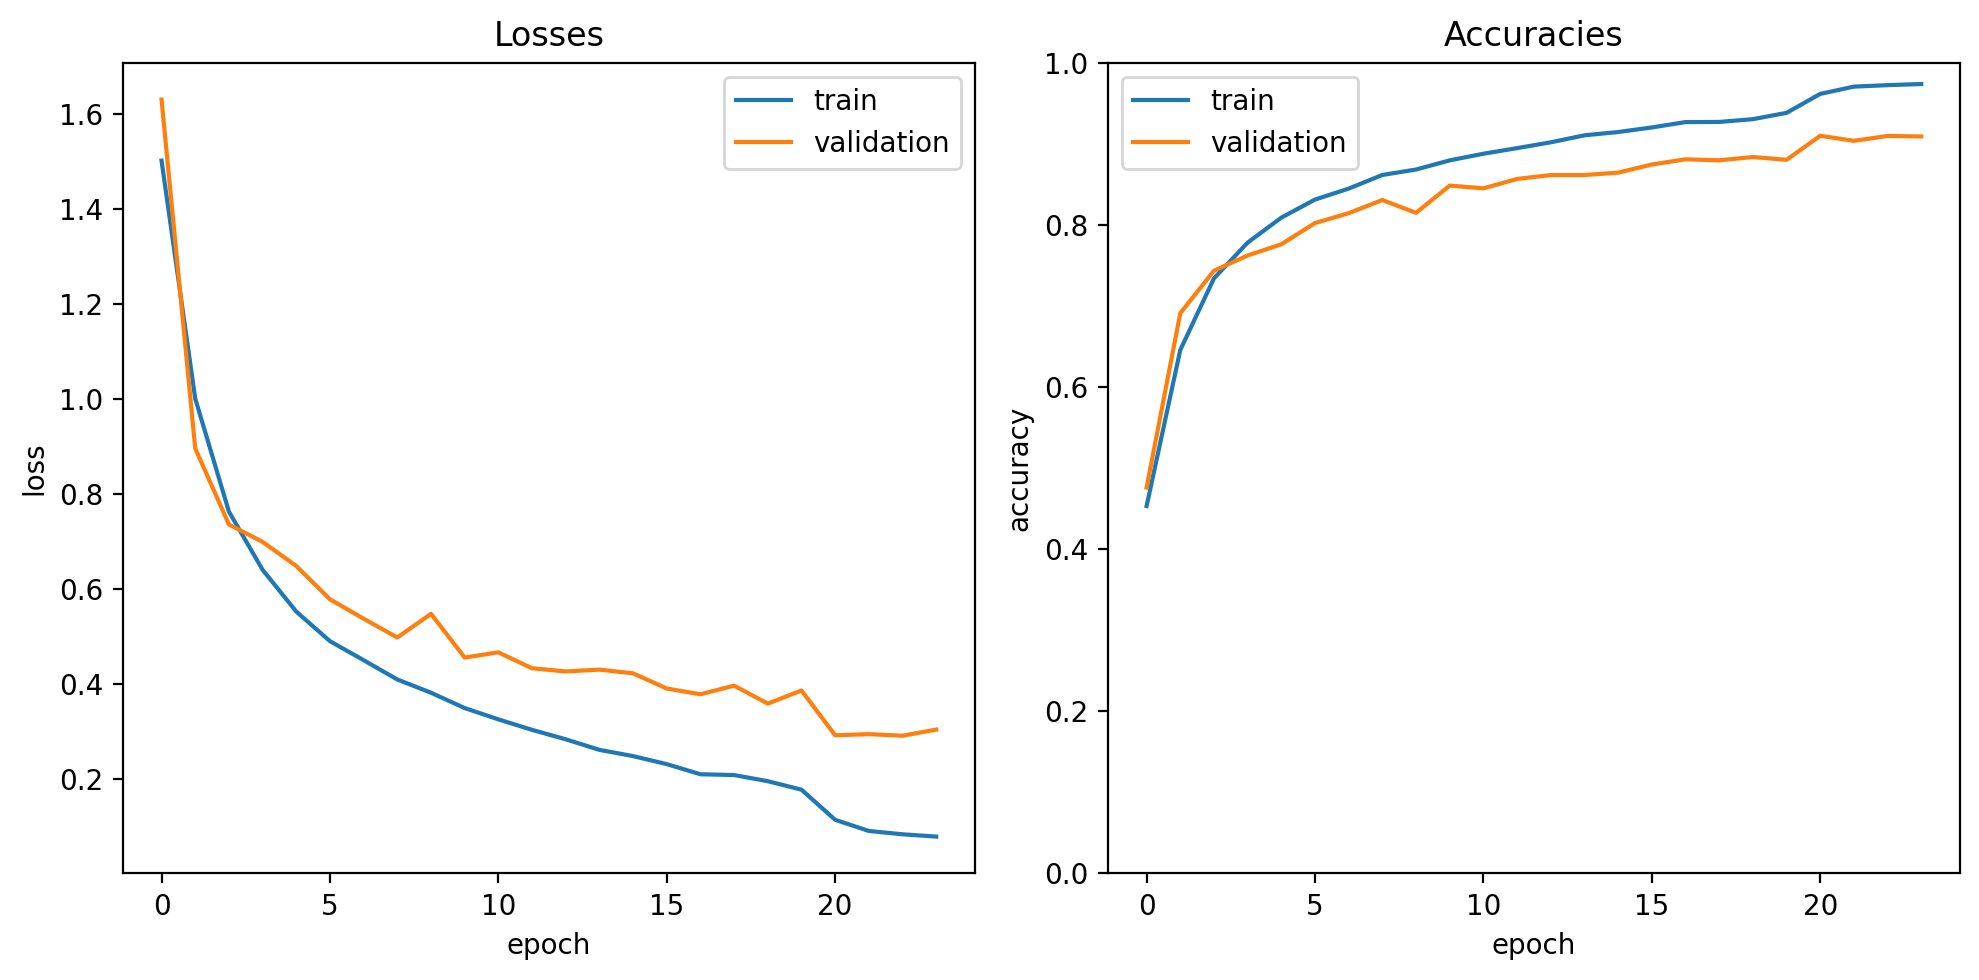

In [51]:
# TODO
plt.figure(dpi=200, figsize=(10, 5))

plt.subplot(121)
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Losses')
plt.legend()

plt.subplot(122)
plt.plot(train_accs, label='train')
plt.plot(val_accs, label='validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim(0, 1)
plt.title('Accuracies')

plt.tight_layout()
plt.show()

In [52]:
net = ResNet18()
net.to(device)
net.load_state_dict(torch.load('bestmodel.pth'))

<All keys matched successfully>

## Evaluation

Test your trained model (using the Test Dataloader that you have). Our goal is to reach an accuracy above `80%`

In [53]:
# TODO
test_avg_loss, test_acc = eval_epoch(net, criterion, testloader, False)
print(test_avg_loss, test_acc)

0.2916323803424835 0.9122


## Visualize incorrectly predicted samples from testset

Visualize *24* random images from testset that are incorrectly predicted by the model

In [54]:
net.eval()
net.to(device)
incorrect_images = []
incorrect_labels_pred = []
incorrect_labels_true = []
correct_indices = []

with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        predicted = predicted.cpu()
        incorrect_mask = predicted != labels
        incorrect_images.extend(images[incorrect_mask])
        incorrect_labels_pred.extend(predicted[incorrect_mask])
        incorrect_labels_true.extend(labels[incorrect_mask])
        correct_indices.extend(labels[~incorrect_mask])

    incorrect_images = torch.stack(incorrect_images).cpu()
    incorrect_labels_pred = torch.stack(incorrect_labels_pred).cpu()
    incorrect_labels_true = torch.stack(incorrect_labels_true).cpu()
    correct_indices = torch.stack(correct_indices).cpu()

random_indices = np.random.choice(len(incorrect_images), 24, replace=False)
selected_images = [incorrect_images[i] for i in random_indices]
selected_labels_pred = [incorrect_labels_pred[i] for i in random_indices]
selected_labels_true = [incorrect_labels_true[i] for i in random_indices]

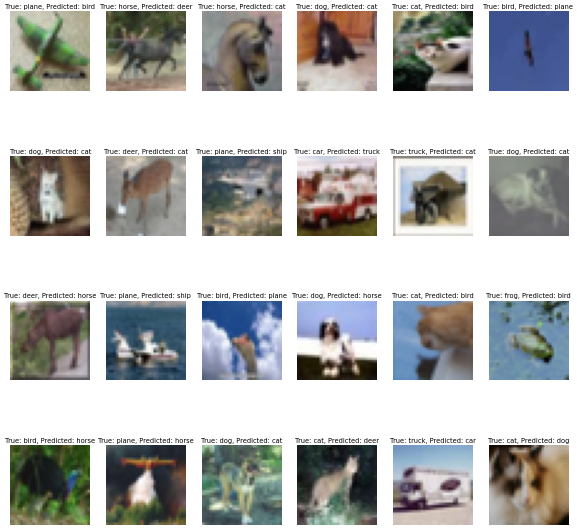

In [55]:
plt.figure(figsize=(18, 18))
for i in range(24):
    plt.subplot(4, 6, i + 1)
    plt.imshow(norminv(selected_images[i]).permute(1, 2, 0))
    plt.title(f"True: {classes[selected_labels_true[i]]}, Predicted: {classes[selected_labels_pred[i]]}")
    plt.axis('off')
plt.show()

## Exploring the feature space

### Calculate the feature space for all training samples

You have trained and evaluated your model. Now, for each sample in the trainset, calculate it's "feature space" discussed in the model section. The result of this section should be a tensor of size `(50000, N)` saved in a variable (for later usage)

- **Hint 1:** define a tensor with dimension `(50000, N)` where *50000* is the size of the trainset and *N* is the dimension of the feature space

- **Hint 2:** Pay attension to the `shuffle` attribute of your train dataloader (If needed)

In [56]:
trainloader2 = torch.utils.data.DataLoader(initial_trainset, batch_size=100, shuffle=False)

clipped = nn.Sequential(*list(net.children())[:-1])
clipped.eval()
clipped.to(device)
space = []
label = []
with torch.no_grad():
    for images, labels in trainloader2:
        images = images.to(device)
        outputs = clipped(images)        
        space.append(outputs.cpu().detach().view(outputs.shape[0], 512))
        label.append(labels)

train_data = torch.cat(space).cpu()
labell = torch.cat(label).cpu()

print(train_data.shape, labell.shape)

torch.Size([50000, 512]) torch.Size([50000])


### K Nearest Neighbor in feature space

You already have calculated the feature spaces for trainset ($S$) in the previous section

1. Get 5 random samples from testset which are correctly predicted by the model.
2. for each sample, calculate it's "feature space" ($X$)
3. for each sample, calculate it's *5* nearest neighbors in "feature space" in the trainset (by comparing $X$ to each row in $S$) and visualize them


**Hint:** For finding the nearest neighbors in the feature space you can use `torch.linalg.norm` and `torch.topk`

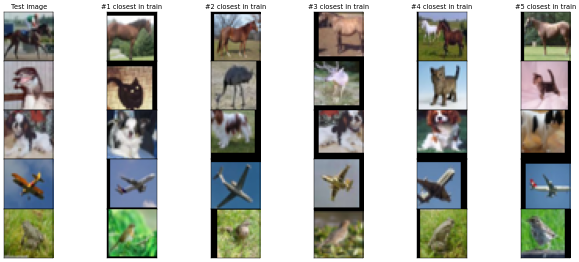

In [59]:
cnt = 0

clipped.eval()
clipped.to(device)
train_data = train_data.to(device)

indices = torch.randint(0, len(correct_indices), (5,))



figs, axs = plt.subplots(5, 6, sharex=True, sharey=True, figsize=(20, 8))
axs[0, 0].set_title('Test image')

for i in range(1, 6):
    axs[0, i].set_title(f'#{i} closest in train')

with torch.no_grad():
    for enum, idx in enumerate(indices):
        img = testset[idx][0].view(1, 3, 32, 32).to(device)
        out = clipped(img).view(1, 512)
        _, similar_indices = torch.topk(torch.linalg.norm(train_data - out, dim=1), k=5, largest=False)
        
        sim_img = testset[idx][0]
        img = norminv(sim_img.cpu()).numpy().transpose(1, 2, 0)
        axs[enum, 0].imshow(img)
        axs[enum, 0].get_xaxis().set_visible(False)
        axs[enum, 0].get_yaxis().set_visible(False)
        
        
        for i in range(len(similar_indices)):
            sim_img = initial_trainset[similar_indices[i]][0]
            img = norminv(sim_img.cpu()).numpy().transpose(1, 2, 0)
            axs[enum, i+1].imshow(img)
            axs[enum, i+1].get_xaxis().set_visible(False)
            axs[enum, i+1].get_yaxis().set_visible(False)


plt.subplots_adjust(wspace=0, hspace=0)

### TSNE

1. Sample $M$ ($2000$ would be enought) random samples from the trainset feature space (calculated in the above sections)
2. Now you have a vector of size `(M, N)` where $N$ is the dimension of the feature space
3. Using TSNE reduce $N$ to $2$ (Now you have a vector of size `(M, 2)`)
4. Visualize the points in a 2D plane (Set color of each point based on it's class)

**Hint:** You can use `sklearn.manifold.TSNE`

**Hint:** Use `plt.scatter(x, y, c=labels)`


<Axes: xlabel='x', ylabel='y'>

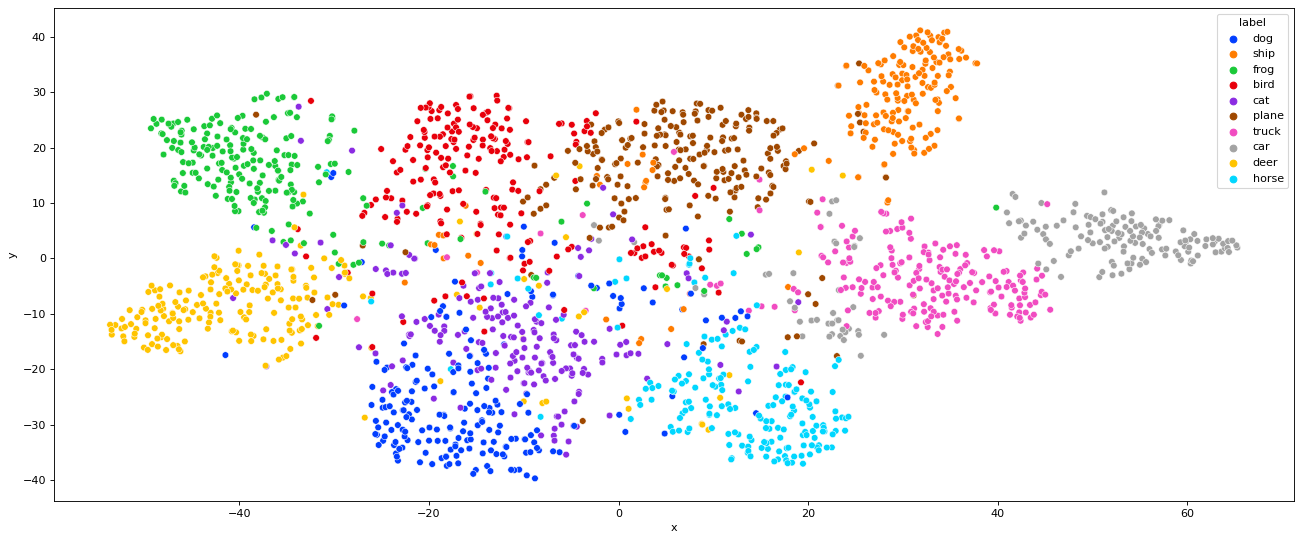

In [64]:
space = []
label = []
with torch.no_grad():
    for images, labels in trainloader:
        images = images.to(device)
        outputs = clipped(images)        
        space.append(outputs.cpu().detach().view(outputs.shape[0], 512))
        label.append(labels)

space = torch.cat(space).cpu()
space_labels = torch.cat(label).cpu()


# TODO

from sklearn.manifold import TSNE
train_data = train_data.cpu()
M = 2000
indices = torch.randperm(space.size(0))[:M]
sampled = space[indices]
labels = space_labels[indices]


N = 512  
num_classes = 10  

tsne = TSNE(n_components=2, random_state=0)
reduced_features = tsne.fit_transform(sampled.data)

indices = torch.randperm(train_data.size(0))[:2000]

X = train_data[indices].cpu().numpy()
y = labell[indices].cpu().numpy()

X_2d = TSNE(2).fit_transform(X)
X_2d.shape

import seaborn as sns
import pandas as pd

plt.figure(figsize=(20, 8), dpi=80)
data = pd.DataFrame({
    'x': X_2d[:,0],
    'y': X_2d[:,1],
    'label': [classes[t] for t in y],
})

cmap = sns.color_palette("bright", 10).as_hex()
sns.scatterplot(data=data, x='x', y='y', hue='label', palette = cmap)

# CIFAR10 Colorization

In this part of the assignment, we want to do an image colorization task using PyTorch on CIFAR10 dataset. We want to train a model that colors  a black-and-white image.

## Import Libraries

Import needed libraries

In [1]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Custom Dataset

Define a custom dataset class by extensing `torch.utils.data.Dataset`

**Notice:** your dataset should output two things: black-and-white image and the RGB image

**Hint:** You don't have to reinvent the wheel. Your class should just be a wrapper for CIFAR10 dataset

In [62]:
import torchvision.transforms.functional as TF
from torch.utils.data import random_split

class BlackAndWhiteCIFAR10(Dataset):
    """
    Define a custom dataset class by extending `torch.utils.data.Dataset`
    this class is a dataset for the CIFAR10 data in pytorch and it has the black and white image of the original CIFAR10 image as the data
    and the original RGB image as the target
    this class is just a wrapper for the torchvision.datasets.CIFAR10 class
    """

    def __init__(self, train=True, root='./data', download=True, transform=None):
        self.dataset = torchvision.datasets.CIFAR10(root=root, train=train, download=download, transform=transform)
        self.gray = transforms.Grayscale()
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        img = self.dataset[index][0]
        return self.gray(img), img

## Transforms & Dataset & Dataloader

**Notice:** Use your defined custom dataset class for defining the datasets

In [63]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [64]:
# transform_train = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.20, 0.20, 0.20))
# ])

# transform_test = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.20, 0.20, 0.20))
# ])

transform_train = transforms.Compose([
    transforms.ToTensor(),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
])

In [65]:
initial_trainset = BlackAndWhiteCIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

Files already downloaded and verified


In [66]:
val_set_size = int(0.1 * len(initial_trainset))  
train_set_size = len(initial_trainset) - val_set_size

trainset, valset = random_split(initial_trainset, [train_set_size, val_set_size])


In [76]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader =  torch.utils.data.DataLoader(valset, batch_size=100, shuffle=False)

## Dataset Visualization

Visualize your dataset (black-and-white image along with the RGB image) by sampling from your trainset

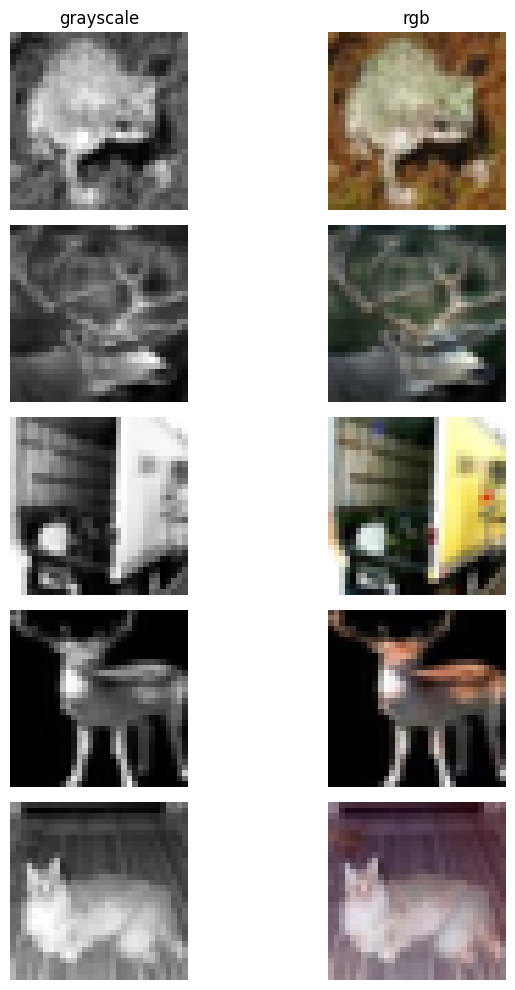

In [77]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

num_samples = 5

fig, axes = plt.subplots(num_samples, 2, figsize=(8, 2*num_samples))

for i in range(num_samples):
    index = torch.randint(len(trainset), size=(1,)).item()

    grayscale_img, rgb_img = trainset[index]
    axes[i, 0].imshow(grayscale_img.permute(1, 2, 0).numpy(), cmap='gray')
    if i == 0:
        axes[i, 0].set_title('grayscale')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(rgb_img.permute(1, 2, 0).numpy())
    if i == 0:
        axes[i, 1].set_title('rgb')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()


## Model

Define your model here (Input: black-and-white image, Output: RGB image)

**Hint:** You can implement an autoencoder that does the colorization task for you. UNet could be a viable option

In [78]:
import torch.nn as nn
import torch.nn.functional as F





class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = conv_block(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        dy = x2.size()[2] - x1.size()[2]
        dx = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (dx//2, (dx+1)//2, dy//2, (dy+1)//2))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class UNet(nn.Module):
    def __init__(self, n_channels=3):
        super(UNet, self).__init__()
        self.encoder1 = conv_block(1, 64)
        self.encoder2 = nn.Sequential(nn.MaxPool2d(2), conv_block(64, 128))
        self.encoder3 = nn.Sequential(nn.MaxPool2d(2), conv_block(128, 256))
        self.encoder4 = nn.Sequential(nn.MaxPool2d(2), conv_block(256, 512))
        self.bottleneck = nn.Sequential(nn.MaxPool2d(2), conv_block(512, 512))
        self.decoder1 = UpBlock(1024, 256)
        self.decoder2 = UpBlock(512, 128)
        self.decoder3 = UpBlock(256, 64)
        self.decoder4 = UpBlock(128, 64)
        self.outc = nn.Conv2d(64, n_channels, kernel_size=1)

    def conv_block(in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True)
        )

    def forward(self, x):
        x1 = self.encoder1(x)
        x2 = self.encoder2(x1)
        x3 = self.encoder3(x2)
        x4 = self.encoder4(x3)
        x5 = self.bottleneck(x4)
        x = self.decoder1(x5, x4)
        x = self.decoder2(x, x3)
        x = self.decoder3(x, x2)
        x = self.decoder4(x, x1)
        x = self.outc(x)
        return x

In [79]:
!pip install torchsummary

^C
ERROR: Operation cancelled by user


## Train

Train your model

Tasks:
- [ ] Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Validation loss
- [ ] save train/validation loss (of each epoch) in an array for later usage

In [80]:
from torchsummary import summary

net = UNet()  
net.to(device)
summary(net, input_size=(1, 32, 32)) 


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]             640
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         LeakyReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
         LeakyReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
       BatchNorm2d-9          [-1, 128, 16, 16]             256
        LeakyReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
        LeakyReLU-13          [-1, 128, 16, 16]               0
        MaxPool2d-14            [-1, 12

In [81]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0002, betas=(0.9, 0.999))

In [82]:
import tqdm
from time import time

In [83]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

def train_epoch(net: nn.Module, criterion: nn.Module, optimizer: optim.Optimizer, dataloader: data.DataLoader):
    net.train()  
    
    running_loss = 0.0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)        
        optimizer.zero_grad()  
        outputs = net(inputs)
        
        loss = criterion(outputs, labels)  
        loss.backward()  
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)  
    
    
    return running_loss / len(dataloader.dataset)
    
def eval_epoch(net: nn.Module, criterion: nn.Module, dataloader: data.DataLoader, test_mode: bool = False):
    net.eval() 
    running_loss = 0.0
    
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device) 
            
            outputs = net(inputs)  
            loss = criterion(outputs, labels)   
            running_loss += loss.item() * inputs.size(0) 
    
    epoch_loss = running_loss / len(dataloader.dataset)  
    
    return epoch_loss


In [85]:
epochs = 12
val_losses = []
train_losses = []
running_train_losses = []
for e in range(epochs):
    running = train_epoch(net, criterion, optimizer, trainloader)
    val_loss = eval_epoch(net, criterion, valloader, False)
    train_loss = eval_epoch(net, criterion, trainloader, False)
    
    
    print(f"Epoch {e+1}/{epochs}: TrainLoss: {train_loss:.4f}, ValLoss: {val_loss:.4f}")
    
    val_losses.append(val_loss)
    train_losses.append(train_loss)    
    running_train_losses.append(running)

Epoch 1/12: TrainLoss: 0.0093, ValLoss: 0.0092
Epoch 2/12: TrainLoss: 0.0056, ValLoss: 0.0056
Epoch 3/12: TrainLoss: 0.0054, ValLoss: 0.0054
Epoch 4/12: TrainLoss: 0.0056, ValLoss: 0.0056
Epoch 5/12: TrainLoss: 0.1002, ValLoss: 0.0977
Epoch 6/12: TrainLoss: 0.0052, ValLoss: 0.0052
Epoch 7/12: TrainLoss: 0.0052, ValLoss: 0.0052
Epoch 8/12: TrainLoss: 0.0052, ValLoss: 0.0052
Epoch 9/12: TrainLoss: 0.0054, ValLoss: 0.0055
Epoch 10/12: TrainLoss: 0.0053, ValLoss: 0.0055
Epoch 11/12: TrainLoss: 0.0049, ValLoss: 0.0050
Epoch 12/12: TrainLoss: 0.0049, ValLoss: 0.0051


### Visualize Loss plot

Using the arrays that you have (from task 2 in the above section), visualize the loss plot (train and validation together)

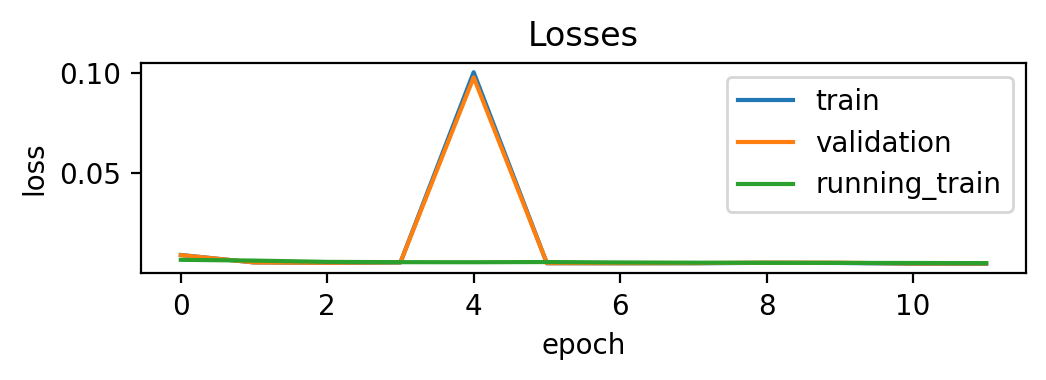

In [89]:
# TODO
plt.figure(dpi=200, figsize=(10, 2))

plt.subplot(121)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='validation')
plt.plot(running_train_losses, label='running_train')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Losses')
plt.legend()

plt.tight_layout()
plt.show()

## Evaluation

1. Sample 36 random samples from testset (your own dataset class)
2. Give each of the 36 samples to your trained model and get the outputs
3. Visualize `input` (black-and-white image), `output` (output of the model with the given black-and-white input image) and `ground truth` (the actual RGB image)



In [90]:
testset =BlackAndWhiteCIFAR10(root='./data', train=False,
                                        download=True, transform=transform_train)
testloader = torch.utils.data.DataLoader(valset, batch_size=100, shuffle=False)

Files already downloaded and verified


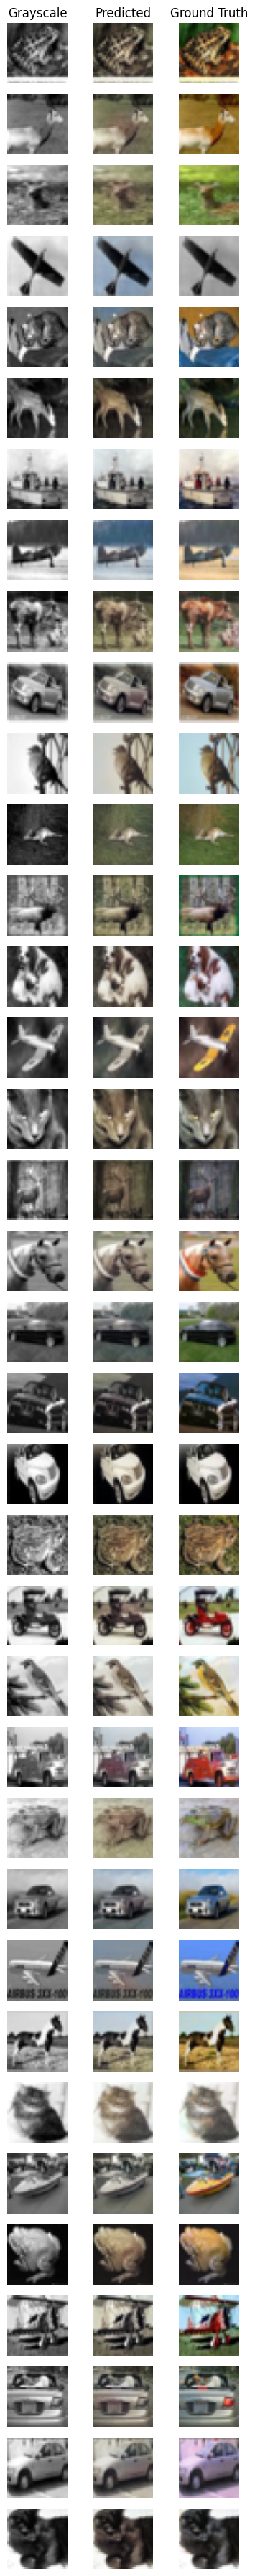

In [114]:
import matplotlib.pyplot as plt
import random

net.eval()


num_samples = 36

fig, axes = plt.subplots(num_samples, 3, figsize=(4, num_samples))

for i in range(num_samples):
    index = random.randint(0, len(testset) - 1)
    input_image, ground_truth = testset[index]
    input_image = input_image.to(device)
    with torch.no_grad():
        output = net(input_image.unsqueeze(0)).view(3, 32, 32)


    axes[i, 0].imshow(input_image.cpu().permute(1, 2, 0).numpy(), cmap='gray')
    if i == 0:
        axes[i, 0].set_title('Grayscale')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(output.cpu().permute(1, 2, 0).numpy())
    if i == 0:
        axes[i, 1].set_title('Predicted')
    axes[i, 1].axis('off')
    
    axes[i, 2].imshow(ground_truth.permute(1, 2, 0).numpy())
    if i == 0:
        axes[i, 2].set_title('Ground Truth')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()
